# Preprocessing

### Setup

In [25]:
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple


seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000.0




### Download the dataset

In [26]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )



filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


### Process a sample file

In [27]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*int(_SAMPLING_RATE)]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)


sample_file = filenames[1]
print(sample_file)
pm = pretty_midi.PrettyMIDI(sample_file)
display_audio(pm)

data\maestro-v2.0.0\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.midi
Fs pretty_midi:  16000.0
Fs instrument:  16000.0


In [28]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


#### Extract notes

In [29]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=31, note_name=G1, duration=0.0656
1: pitch=43, note_name=G2, duration=0.0792
2: pitch=44, note_name=G#2, duration=0.0740
3: pitch=32, note_name=G#1, duration=0.0729
4: pitch=34, note_name=A#1, duration=0.0708
5: pitch=46, note_name=A#2, duration=0.0948
6: pitch=48, note_name=C3, duration=0.6260
7: pitch=36, note_name=C2, duration=0.6542
8: pitch=53, note_name=F3, duration=1.7667
9: pitch=56, note_name=G#3, duration=1.7688


In [30]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [31]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,43,1.032292,1.111458,0.000000,0.079167
1,31,1.040625,1.106250,0.008333,0.065625
2,44,1.142708,1.216667,0.102083,0.073958
3,32,1.144792,1.217708,0.002083,0.072917
4,46,1.208333,1.303125,0.063542,0.094792


In [32]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['G2', 'G1', 'G#2', 'G#1', 'A#2', 'A#1', 'C3', 'C2', 'F3', 'D4'],
      dtype='<U3')

In [48]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

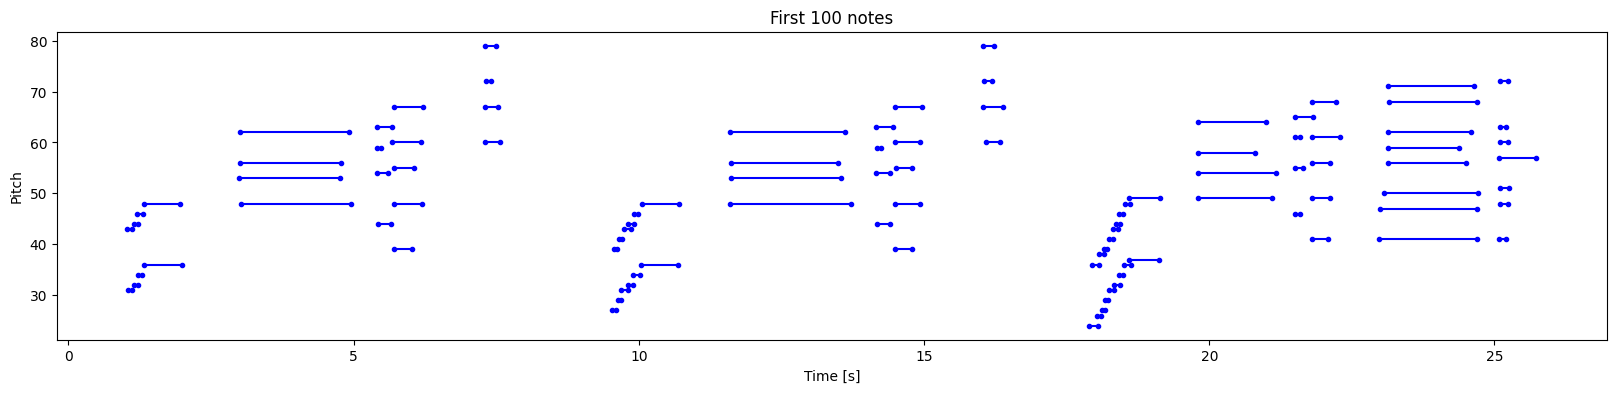

In [49]:
plot_piano_roll(raw_notes, count=100)

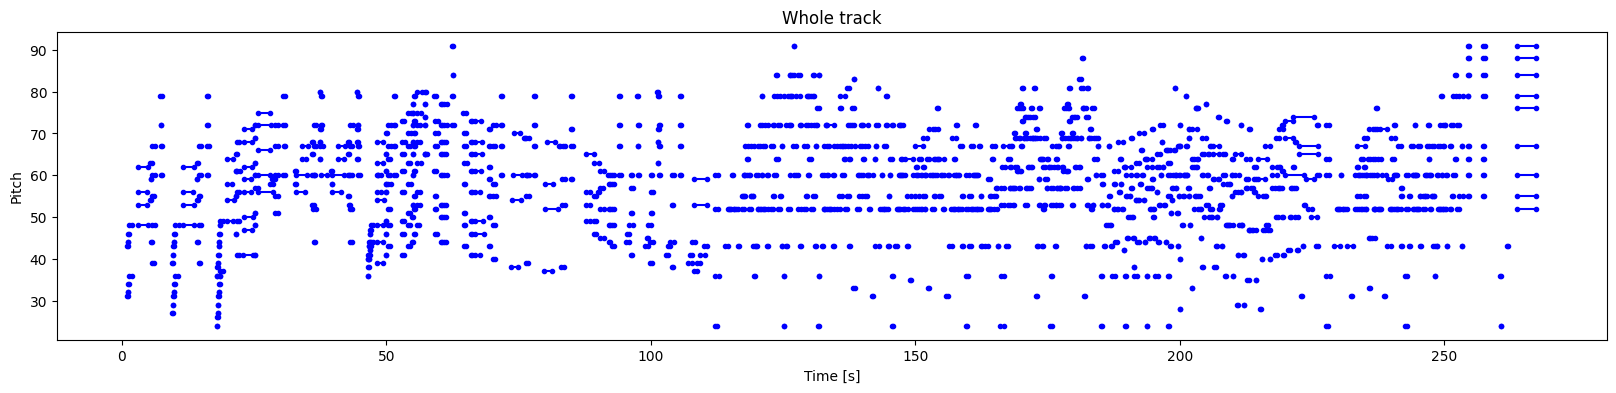

In [50]:
plot_piano_roll(raw_notes)

In [36]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

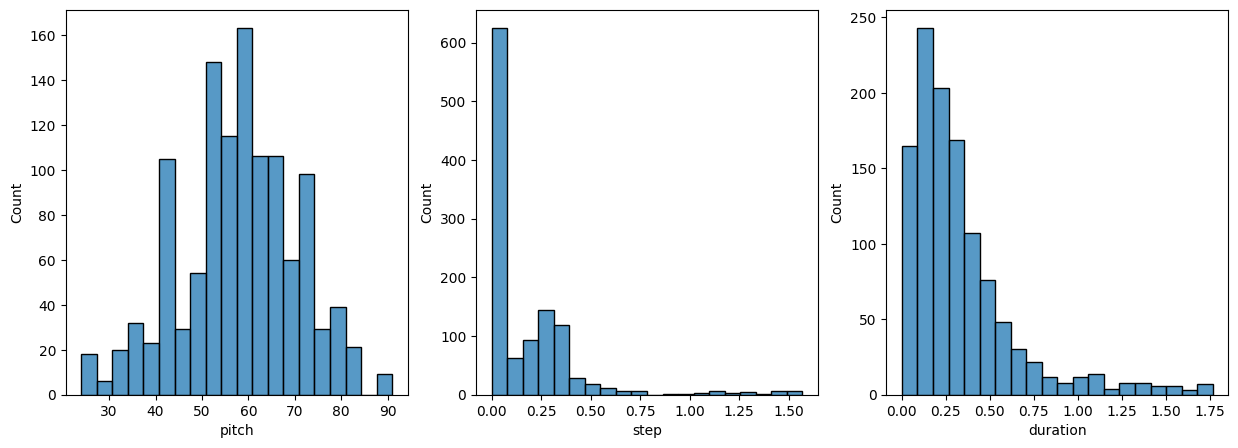

In [37]:
plot_distributions(raw_notes)

In [38]:
#-------------- CREATE MIDI--------------
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [39]:
display_audio(example_pm)

Fs pretty_midi:  16000.0
Fs instrument:  16000.0


In [66]:
#----------------------------------------------------------------

from music21 import converter, note, chord, instrument
import glob
import re

# Maps pitches and note durations to their corresponding input midi file


class PlayedNote:
    def __init__(self, note, duration):
        self.note = note
        self.duration = duration

    def __str__(self):
        return f'note: {self.note}, duration: {self.duration}'

def parse_midi_data(file):
    midi_data = {}
    min_duration = 100
    notes = []
    duration = []
    
    midi = converter.parse(file)
    notes_to_parse = None
    instrument_parts = instrument.partitionByInstrument(midi)
    if instrument_parts:  # File is partitioned by instrument
        notes_to_parse = instrument_parts.parts[0].recurse()
    else:
        notes_to_parse = midi.flat.notes
    for elem in notes_to_parse:
        if isinstance(elem, note.Note):
            notes.append(str(elem.pitch.midi))
            duration.append(elem.duration.quarterLength)
            if elem.duration.quarterLength < min_duration:
                min_duration = elem.duration.quarterLength
        elif isinstance(elem, chord.Chord):
            notes.append('.'.join(str(n) for n in elem.normalOrder))
            duration.append(elem.duration.quarterLength)
    if len(notes) != 0:  # Filter out songs with no notes and chords
        cleaned_file_name = 'uhuhuhu.mid' # re.findall(r'edm_midi\\(.*)\.mid', str(file))[0]
        midi_data[cleaned_file_name] = [None] * len(notes)
        for i in range(len(notes)):
            midi_data[cleaned_file_name][i] = PlayedNote(notes[i], duration[i])
    return midi_data[cleaned_file_name] # midi_data

In [73]:
from PIL import Image, ImageDraw

def generate_image(song_data):
    length = 0
    
    width = len(song_data) #96 było
    for note in song_data:
        length += note.duration
    img = Image.new(mode = "RGB", size = (128, width))
    drawer = ImageDraw.Draw(img)
    current_index = 0
    image_num = 0
    for note in song_data:
        for sub_note in note.note.split("."):
            drawer.line([(current_index, width - int(sub_note)), (current_index + note.duration * 4, width - int(sub_note))], fill = (255, 255, 255))
        # img.show()
        current_index += note.duration * 4

        if current_index % 96 != current_index:
            current_index = 0
            img.save(f'sample{image_num}.png') #(f'edm_images/{name.replace(" ", "_")}_{image_num}.png')
            image_num += 1
            img = Image.new(mode = "RGB", size = (128, 96))
            drawer = ImageDraw.Draw(img)
    img.show()
    img.save(f'sample{image_num}.png') #(f'edm_images/{name.replace(" ", "_")}_{image_num}.png')

In [74]:
sample_song_data = parse_midi_data(sample_file)
print(sample_song_data)
generate_image(sample_song_data)

[<__main__.PlayedNote object at 0x00000257316500A0>, <__main__.PlayedNote object at 0x000002572E885FD0>, <__main__.PlayedNote object at 0x000002572EAE47F0>, <__main__.PlayedNote object at 0x0000025731AC90D0>, <__main__.PlayedNote object at 0x0000025731AC9100>, <__main__.PlayedNote object at 0x0000025731AC9040>, <__main__.PlayedNote object at 0x0000025731AC91F0>, <__main__.PlayedNote object at 0x000002572FECDAC0>, <__main__.PlayedNote object at 0x000002572FECDAF0>, <__main__.PlayedNote object at 0x000002572FECDB50>, <__main__.PlayedNote object at 0x000002572FECDBB0>, <__main__.PlayedNote object at 0x000002572FECDC10>, <__main__.PlayedNote object at 0x000002572FECDC70>, <__main__.PlayedNote object at 0x000002572FECDCD0>, <__main__.PlayedNote object at 0x000002572FECDD30>, <__main__.PlayedNote object at 0x000002572FECDD90>, <__main__.PlayedNote object at 0x000002572FECDDF0>, <__main__.PlayedNote object at 0x000002572FECDE50>, <__main__.PlayedNote object at 0x000002572FECDEB0>, <__main__.P

In [133]:
#-----------------------------------------------------------------------------------------
# Raczej nie bd tego używać
def image_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if not count:
        count = len(notes['pitch'])
    fig = plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b")  #, marker=".")
    plt.xlim([0, count/4+1])
    plt.ylim([0, 96])
    plt.axis('off')
    plt.savefig('buuuuuuuuuu.png', bbox_inches='tight')
    plt.show()

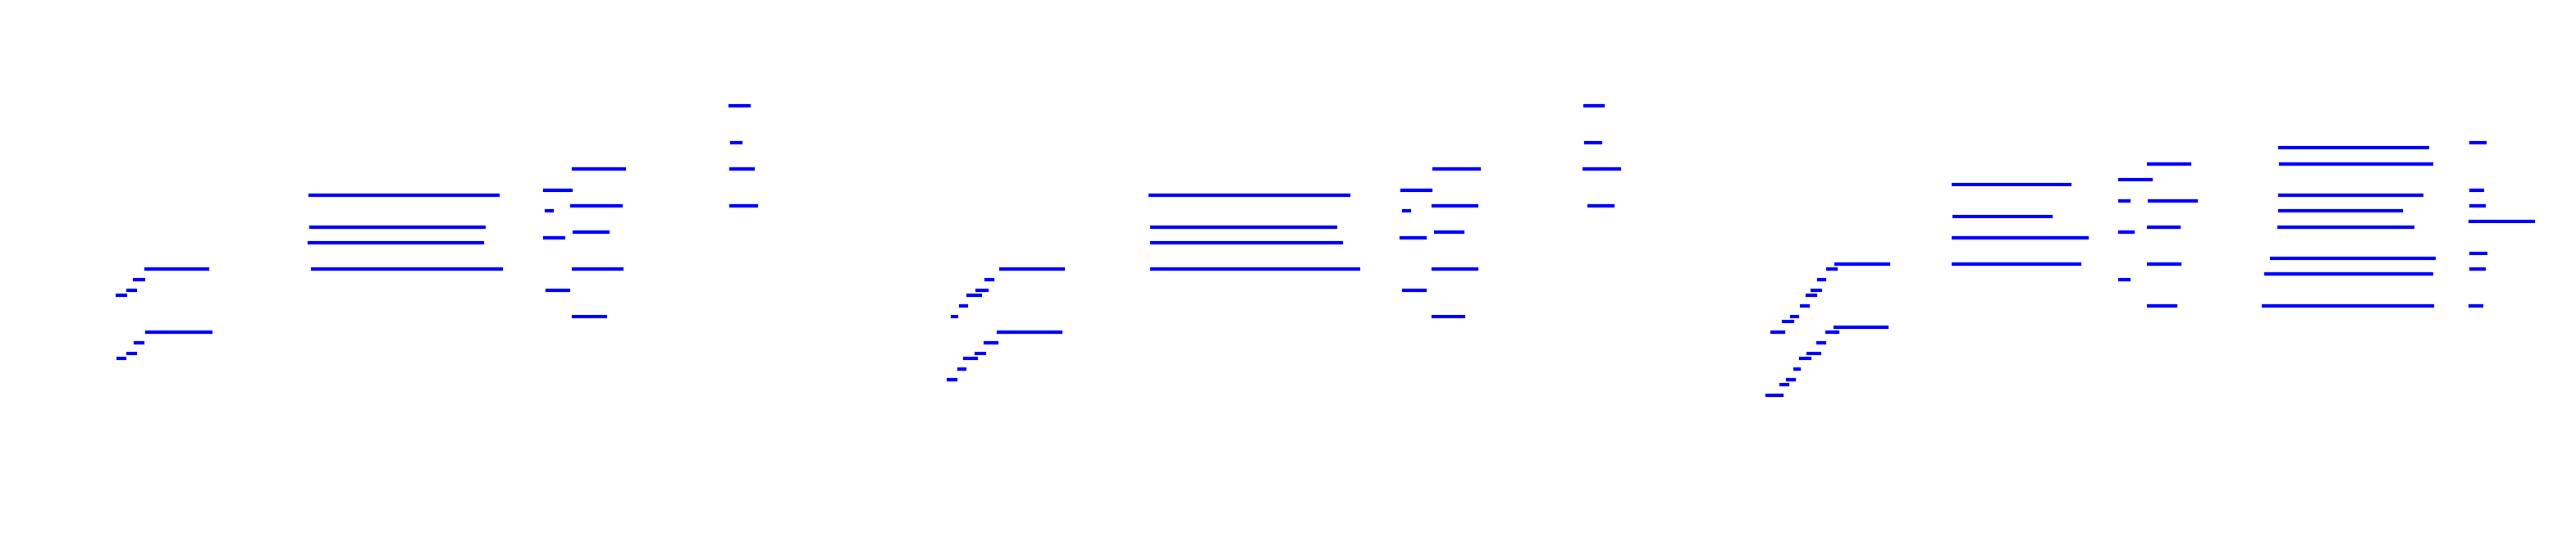

In [134]:
image_piano_roll(raw_notes, count=100)

In [137]:
from PIL import Image

print(Image.open('buuuuuuuuuu.png').size)

(1570, 328)


(10000, 96)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(10000, 96)


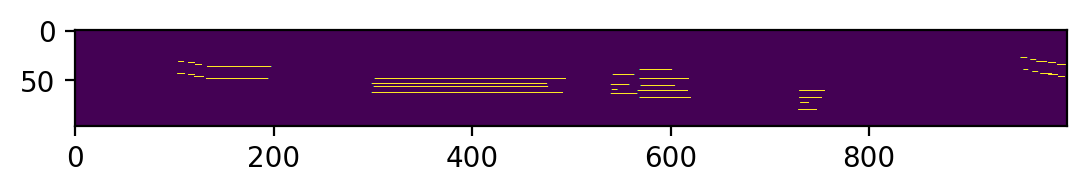

In [161]:
# prawdopodobnie to będzie wkładane do gana
def array_piano_roll(notes: pd.DataFrame, count: Optional[int] = None, precision = 2): # precision - do ilu miejsc po przecinku części sekundy zaokrąglamy
    if not count:
        count = len(notes['pitch'])
    
    max_pitch = 96
    result = np.zeros((count * (10**precision), max_pitch))
    print(result.shape)
    for i in range(count):
        start = int(notes['start'][i] * (10**precision))
        end = int(notes['end'][i] * (10**precision))
        result[start:end, notes['pitch'][i]] = 1
        
    return result

from matplotlib import pyplot as plt
arr = array_piano_roll(raw_notes, count=100)
print(arr)
print(arr.shape)
bubu = np.transpose(arr)
plt.imshow(np.transpose(arr)[:, :1000])

In [168]:
def array_to_notes(array, precision):
    max_pitch = 96
    notes = collections.defaultdict(list)
    for pitch in range(max_pitch):
        note_started = False
        prev_start = 0.0
        current_start = 0.0
        current_end = 0.0
        for timestamp in range(len(array)):
            if array[timestamp, pitch] == 1 and not note_started:
                note_started = True
                current_start = timestamp / (10**precision)
            elif array[timestamp, pitch] == 0 and note_started:
                note_started = False
                current_end = timestamp / (10**precision)
                
                notes['pitch'].append(pitch)
                notes['start'].append(current_start)
                notes['end'].append(current_end)
                notes['step'].append(current_start - prev_start)
                notes['duration'].append(current_end - current_start)
                prev_start = current_start
    
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})   
    

In [169]:
notes2 = array_to_notes(arr, 2)
notes2.head()

,pitch,start,end,step,duration
0,24,17.89,18.05,17.89,0.16
1,26,18.03,18.10,18.03,0.07
2,27,9.53,9.60,9.53,0.07
3,27,18.11,18.17,8.58,0.06
4,29,9.63,9.69,9.63,0.06


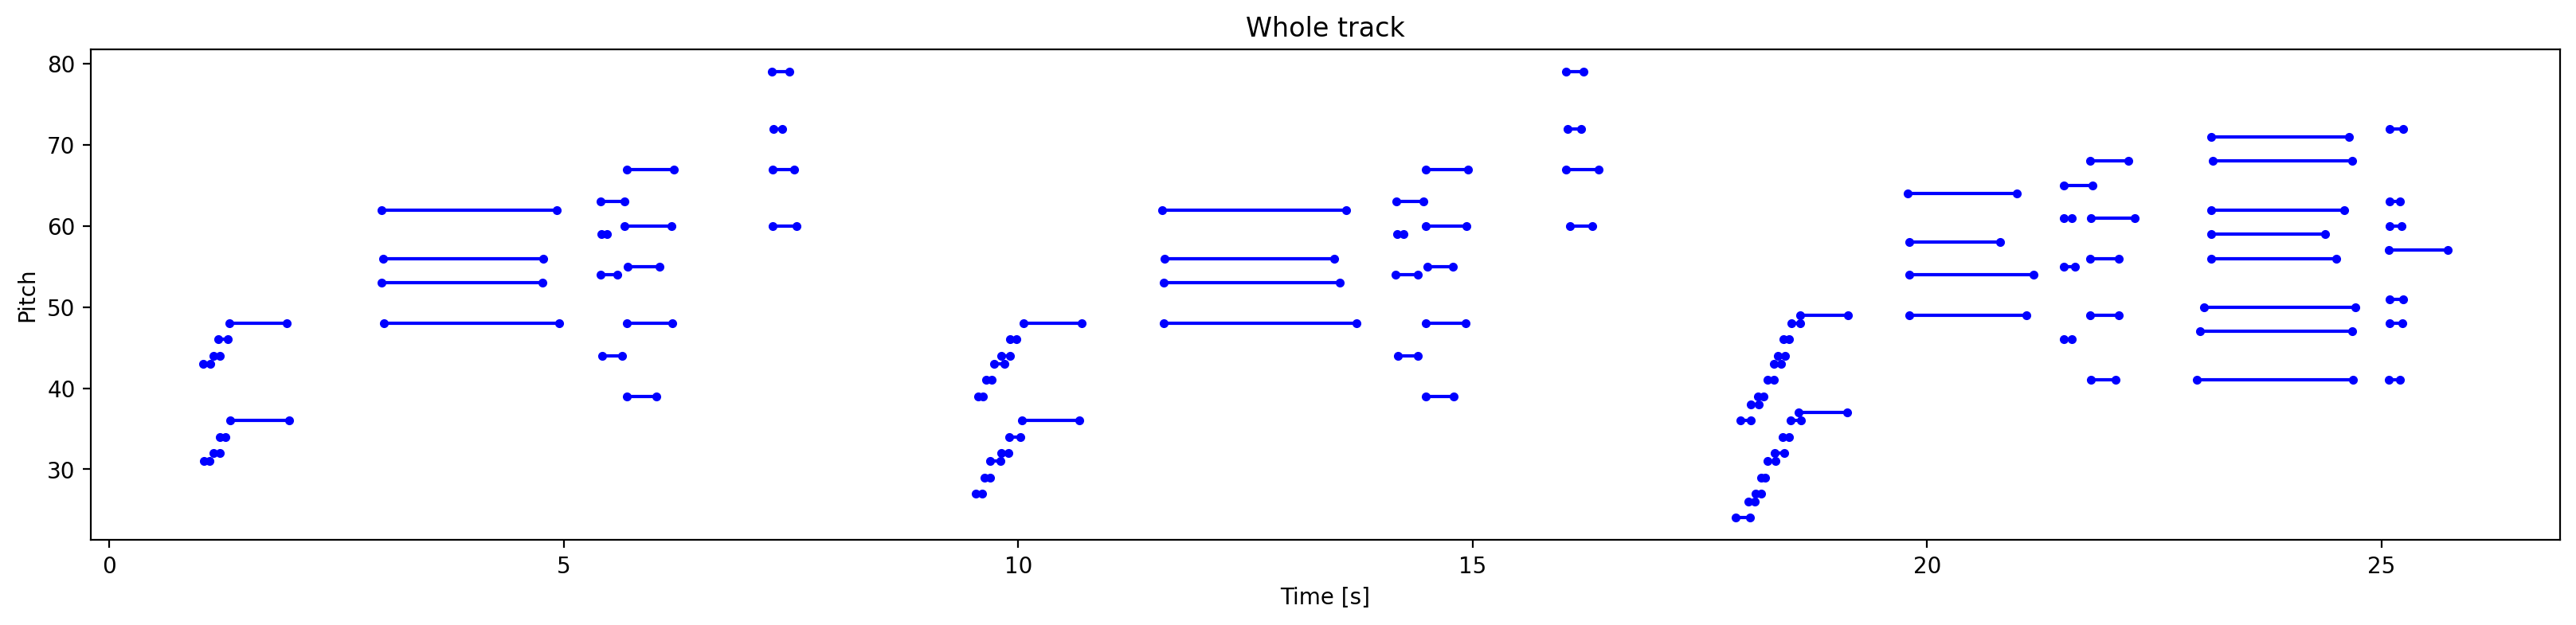

In [170]:
plot_piano_roll(notes2)

Teraz:
1. zrobić model
2. wrzucać na wejście modelu nupmy arraye, ew. zreshapowane LUB przerobione na obrazy
3. wyciągać numpy arraye i robić z nich midi

# Stare, prawdopodobnie śmieci:

In [104]:
# from midi_data_extractor import PlayedNote
from music21 import *

def convert_data_to_midi(input_data, name, percent):
    print("Turning data into midi stream")
    _stream = stream.Stream()

    invert = 1
    if percent < .50:
        invert = -1

    for x in range(len(input_data[0])) :
        notes = []
        for y in range(len(input_data)):
            if input_data[y][x] * invert > percent * invert:
                notes.append(note.Note(96 - y))
        midi_note = None
        if len(notes) > 0:
            midi_note = chord.Chord(notes)
        else:
            midi_note = note.Note(0)
        midi_note.duration.quarterLength = 0.25
        _stream.append(midi_note)
    print(f"Creating midi file with name {name}")
    _converter = converter.Converter().getSubConverterFormats()["midi"]().write(_stream, "midi", f"{name}.mid")
    return stream

In [106]:
import imageio as iio
 
# read an image
img = iio.imread("buuuuuuuuuu.png")

print(img.shape)
cos = convert_data_to_midi(img, 'teojastara', 100)

C:\Users\gosia\AppData\Local\Temp\ipykernel_1516\3771632112.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = iio.imread("buuuuuuuuuu.png")


(328, 1570, 4)
Turning data into midi stream


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

\
\
\
\
\
\
\
\
\
\
\
\
\
\

\

In [100]:
def mid2array(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]





def array2mid(ary, tempo=500000):
    # get the difference
    new_ary = np.concatenate([np.array([[0] * 88]), np.array(ary)], axis=0)
    changes = new_ary[1:] - new_ary[:-1]
    # create a midi file with an empty track
    mid_new = mido.MidiFile()
    track = mido.MidiTrack()
    mid_new.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
    # add difference in the empty track
    last_time = 0
    for ch in changes:
        if set(ch) == {0}:  # no change
            last_time += 1
        else:
            on_notes = np.where(ch > 0)[0]
            on_notes_vol = ch[on_notes]
            off_notes = np.where(ch < 0)[0]
            first_ = True
            for n, v in zip(on_notes, on_notes_vol):
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_on', note=n + 21, velocity=v, time=new_time))
                first_ = False
            for n in off_notes:
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_off', note=n + 21, velocity=0, time=new_time))
                first_ = False
            last_time = 0
    return mid_new




def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]
def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result





def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in str.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in str.punctuation})))
    return [result, on_]

In [101]:
import mido
mid = mido.MidiFile(sample_file, clip=True)

sample_array = mid2array(mid)
reproduced_sample = array2mid(sample_array)

AttributeError: type object 'str' has no attribute 'punctuation'

# Training

\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
\
### Z tensorflow, do rnn, 5 piosenek naraz

In [ ]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec